# Classification of CIFAR_10 Image Dataset

Our chosen dataset is CIFAR-10. The classes the dataset contains are:
\begin{itemize}
\item airplane
\item automobile
\item bird
\item cat
\item deer
\item dog
\item frog
\item horse
\item ship
\item truck
\end{itemize}
The size of each image in the CIRAR-10 dataset are 3x32x32. It has 3 colour channels namely red, green and blue and 32x32 pixel size.
 
Our aim is to build a neural network classifier that can take an RGB image as an input and accurately determine which of the 10 distinct classes it belongs to. In addition to this, we will also implement an adversarial attack on our trained neural network which would cause our model to misclassify the images. Once sucessful in implementing an effective adversarial attack, we will focus on building a robust model that is resistant to those same attacks.


### Starting Lines and Necessary Imports

\begin{enumerate}

\item Import various pytorch packages for neural network constructing and model training
\item Torchvision used to import, load and transform the dataset
\item Import numpy, pandas packages for data manipulation
\item Import matplotlib, seaborn packages for visualisation
\item Torchsummary used to summarise parameters

\end{enumerate}

In [2]:
from torchsummary import summary
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Google Colab is used to surpass the hardware limitations with our current setup. 
Run the two cells below if using Google Colab (you need to have a folder called AdvMachineLearningProject with the files in it)

In [84]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Create a target folder to store project files

In [85]:
cd /drive/My\ Drive/AdvMachineLearningProject

/drive/My Drive/AdvMachineLearningProject


## Load CIFAR 10 Data using torchvision

### Data Pre-processing (Mean, Standard Deviation and Transforms)

We first calculate the mean and standard deviation of each channel using the dataset without any transformations. These values normalise the images by diving each channel by its standard deviation and subtracting the its mean to get all the pixel values in each channel a range from -1 to 1. 

We also use the transformations ‘RandomCrop’ and ‘HorizontalFlip’ during training to add some stochasticity to our input data. That will produce a model that generalises better to unseen data. These transformations also aid model regularisations.

In [86]:
# Data Sets without any processing
train_dataset_raw = datasets.CIFAR10('CIFAR10',
                                     train=True,
                                     download=True,
                                     transform=transforms.ToTensor())
test_dataset_raw = datasets.CIFAR10('CIFAR10',
                                    train=False,
                                    download=True,
                                    transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def calculate_mean(loader):
    images, labels = iter(loader).next()
    mean = images.sum(dim=(0, 2, 3), keepdim=True)
    mean = mean/images.shape[0]/images.size(2)/images.size(3)
    return mean

In [0]:
def calculate_std(loader, mean):
    images, labels = iter(loader).next()
    std = (images - mean).pow(2).sum(dim=(0, 2, 3), keepdim=True)
    std = torch.sqrt(std/(images.shape[0]*images.size(2)*images.size(3)-1))
    return std

In [0]:
def mean_and_stddev():
    train_loader = torch.utils.data.DataLoader(train_dataset_raw,
                                               batch_size=50000,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset_raw,
                                              batch_size=10000,
                                              shuffle=True)

    tr_mean = calculate_mean(train_loader)
    tst_mean = calculate_mean(test_loader)
    tr_std = calculate_std(train_loader, tr_mean)
    tst_std = calculate_std(test_loader, tst_mean)

    return tr_mean.view(-1), tst_mean.view(-1), tr_std.view(-1), tst_std.view(-1)

#### Mean and Standard Deviation for Training and Test Datasets

In [90]:
tr_mean, tst_mean, tr_std, tst_std = mean_and_stddev()
print(tr_mean)
print(tst_mean)
print(tr_std)
print(tst_std)

tensor([0.4914, 0.4822, 0.4465])
tensor([0.4942, 0.4851, 0.4504])
tensor([0.2470, 0.2435, 0.2616])
tensor([0.2467, 0.2429, 0.2616])


#### Transformations

In [0]:
# Transformations on training set
# Crop, Horizontal Flip, Tensor, Normalize (3 channels)
transform_tr = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(tr_mean, tr_std)
])

# Transformations on testing set
# Tensor and Normalize (3 channels)
transform_tst = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(tst_mean, tst_std)
])

### Load Training and Testing Data

Our dataset consists of 50,000 training images and corresponding labels, as well as 10,000 test images and labels. As the training error is not representative of the generalised error, we split our training image and label sets into a 90/10 training and validation set. Using a validation set will help tune the hyperparameters and evaluate the fit of the model to prevent overfitting of the data.

In [92]:
# Batch Size Hyperparameters
train_batch_size = 32
val_batch_size = 5000  # representing a 90/10 train/validation split
test_batch_size = 5000  # smaller test batches due to memory constraints

# to randomly shuffle data
indices = np.arange(50000)
np.random.shuffle(indices)

# samplers to split into training and validation set
tr_sampler = torch.utils.data.SubsetRandomSampler(indices[:45000])
val_sampler = torch.utils.data.SubsetRandomSampler(indices[45000:50000])


# CIFAR-10 training dataset and data loader
train_dataset = datasets.CIFAR10('CIFAR10',
                                 train=True,
                                 download=True,
                                 transform=transform_tr)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=False,
                                           sampler=tr_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=val_batch_size,
                                         shuffle=False,
                                         sampler=val_sampler)

# CIFAR-10 test dataset and data loader
test_dataset = datasets.CIFAR10('CIFAR10',
                                train=False,
                                download=True,
                                transform=transform_tst)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


#### Check batches and image/label shapes

In [93]:
# check num of batches in each training epoch (should be 45,000/train_batch_size)
print(len(train_loader))
# check num of batches in each training epoch (should be 5,000/val_batch_size = 1)
print(len(val_loader))
# check num of batches in each test epoch (should be 10,000/test_batch_size)
print(len(test_loader))
# check shape
images, labels = iter(train_loader).next()
print(images.shape)  # shape = (train_batch_size, RGB channels, H, W)
print(labels.shape)  # shape = (train_batch_size)

1407
1
2
torch.Size([32, 3, 32, 32])
torch.Size([32])


#### Function to show individual image and associated label

We visualised a grid of 20 randomly selected images from the image set.

In [0]:
def show_images():
    train_loader = torch.utils.data.DataLoader(train_dataset_raw,
                                               batch_size=1,
                                               shuffle=True)

    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = 4

    ax = []
    plt.rcParams.update({'font.size': 22})
    for i in range(1, columns * rows + 1):
        image, label = iter(train_loader).next()
        ax.append(fig.add_subplot(rows, columns, i))
        ax[-1].set_title(
            str(label.item()) + " - " +
            str(train_loader.dataset.classes[label]))
        plt.imshow(np.transpose(image[0], (1, 2, 0)))
    plt.show()
    plt.rcParams.update({'font.size': 12})

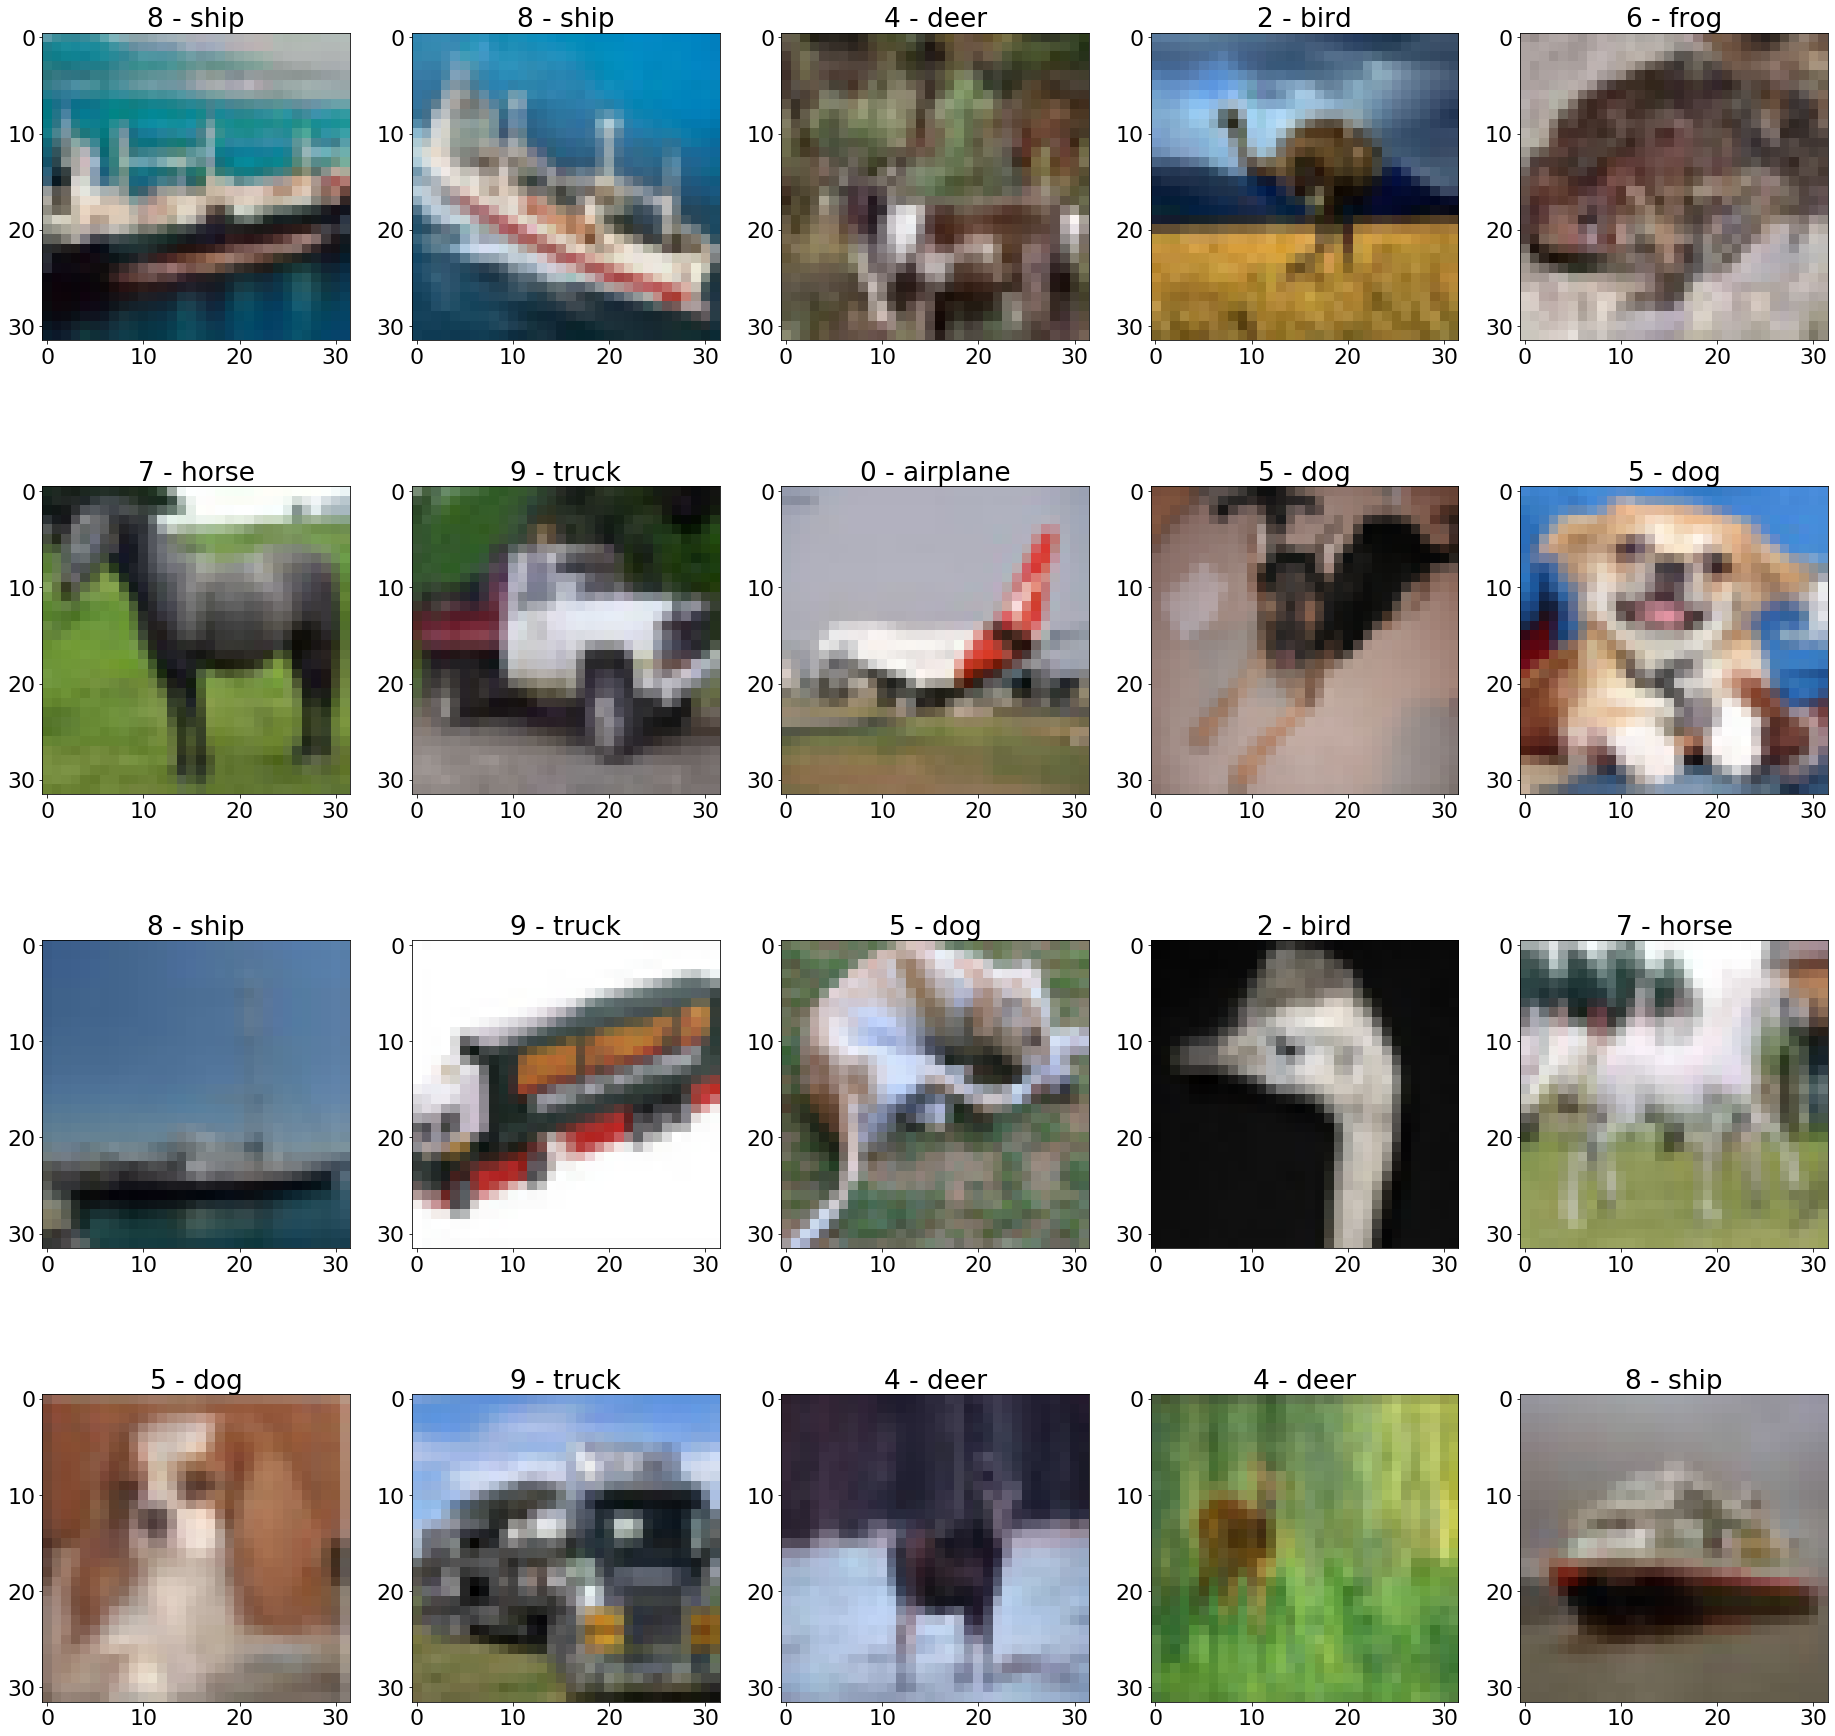

In [95]:
show_images()

# Helper functions for Neural Network

Here we define some helper functions used throughout training and testing of our model.

\textbf{Accuracy function} - comparing model outputs and true labels to give a percentage of correct outputs from 0-100%. This function was used in each training epoch to calculate training and validation loss. The model prediction is the maximum score out of the 10 ouputs (one for each class).

\textbf{GPU check function} - used during training to move training batches to the GPU for calculation, unless a GPU is not available, in that case pytorch will attempt to use the CPU.

\textbf{Reduce step size function} - used during training to reduce step size at specified epochs.

In [0]:
def accuracy(outputs, labels):
    """Function for determining the accuracy of a set of model outputs compared to label values."""
    prediction = outputs.cpu().max(1, keepdim=True)[1].squeeze()
    prediction_comp = torch.eq(prediction.cpu(), labels.cpu())
    prediction_comp = prediction_comp.sum().numpy() / torch.numel(prediction.cpu())
    return prediction_comp * 100

In [0]:
def cpu_or_gpu():
    """Function to determine whether to train using a GPU or CPU."""
    train_on_gpu = torch.cuda.is_available()
    if not train_on_gpu:
        device = torch.device('cpu')
    else:
        device = torch.device('cuda:0')
    return device

In [0]:
def reduce_step_size(iteration_cutoff, old_step_size, new_step_size, epoch):
    """Used in training to reduce step size"""
    step_size = old_step_size
    if epoch == iteration_cutoff:
        step_size = new_step_size
        if epoch == iteration_cutoff:
            print(
                "Log -- Decreased Step size from {} to {}".format(old_step_size, new_step_size))
    return step_size

# Initialize settings for Neural Network

## Main Model

Below is our main model, a convolutional neural network with 5 convolutional layers and one linear ouput layer. 

\textbf{Convolutional Layer 1} - In-channels: 3, Out-channels: 100, ReLU() activation, 3x3 kernel with padding = 1
\begin{itemize}
\item Filter that convolves around the input image, multiplying each of the input pixels in the filter region with a weight then summing to produce a value for that region in a "feature map"
\item In-channels correspond to the channels in the input for the layer
\item Out-channels correspond to the number of feature maps created by the convolutional layer
\item Applies the ReLU() activation function, $y=max(0,x)$, to all values in feature maps
\end{itemize}

\textbf{Max Pooling Layer 1} - 2 x 2
\begin{itemize}
\item Selects the maximum value out of each 2x2 region of each feature map
\item Reduces the size of each feature map by a factor of 2
\end{itemize}

\textbf{Convolutional Layer 2} -  In-channels: 100, Out-channels: 200, 2x2 kernel with padding = 1, ReLU() activation

\textbf{Max Pooling Layer 2}  - 2 x 2

\textbf{Convolutional Layer 3} - In-channels: 200, Out-channels: 300, 2x2 kernel with padding = 1, ReLU() activation

\textbf{Max Pooling Layer 3}  - 2 x 2

\textbf{Convolutional Layer 4} - In-channels: 300, Out-channels: 400, 2x2 kernel with padding = 1, ReLU() activation

\textbf{Max Pooling Layer 4}  - 2 x 2

\textbf{Convolutional Layer 5} - In-channels: 400, Out-channels: 500, 2x2 kernel with padding = 1, ReLU() activation

\textbf{Dropout Layer} - p = 0.5
\begin{itemize}
\item Drop channel with 50% probability
\item Regularizes output of convolutional layers
\end{itemize}

\textbf{Flatten} - From previous convolutional layer into 4500 Nodes

\textbf{Fully Connected Layer} - From 4500 to 10 output weights

In [0]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()

        # 5 Convolutional Layers
        # 100 - 3x3, 200 - 2x2, 300 - 2x2, 400 - 2x2, 500 - 2x2
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.conv2 = nn.Conv2d(100, 200, 2, padding=1)
        self.conv3 = nn.Conv2d(200, 300, 2, padding=1)
        self.conv4 = nn.Conv2d(300, 400, 2, padding=1)
        self.conv5 = nn.Conv2d(400, 500, 2, padding=1)

        # Dropout Layer (p=0.5)
        self.drop = nn.Dropout2d()

        # Max Pooling Layer (2 x 2)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Output Layer
        self.fc1 = nn.Linear(4500, 10)

        # Activation function
        self.activ1 = nn.ReLU()

    def forward(self, x):
        # 5 convolutional / pooling layers
        x = self.activ1(self.conv1(x))
        x = self.pool(x)
        x = self.activ1(self.conv2(x))
        x = self.pool(x)
        x = self.activ1(self.conv3(x))
        x = self.pool(x)
        x = self.activ1(self.conv4(x))
        x = self.pool(x)
        x = self.activ1(self.conv5(x))
        x = self.drop(x)

        # Final Output Layer
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)

        return x

## Other attempts

Throughout the course of bulding our main model, we experimented with various other network architectures, some of  which are shown below as markdown cells. These range from experimentations with different layer types, different levels of normalization and different activation functions. These either had a worse result than our main model or surpassed the level of computation that we had at our disposal.

class Neural_Network_batch_norm(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()

        # 5 Convolutional Layers
        # 100 - 3x3, 200 - 2x2, 300 - 2x2, 400 - 2x2, 500 - 2x2
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.conv2 = nn.Conv2d(100, 200, 2, padding=1)
        self.conv3 = nn.Conv2d(200, 300, 2, padding=1)
        self.conv4 = nn.Conv2d(300, 400, 2, padding=1)
        self.conv5 = nn.Conv2d(400, 500, 2, padding=1)

        # Max Pooling Layer (2 x 2)
        self.maxpool = nn.MaxPool2d(2, 2)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(100)
        self.bn2 = nn.BatchNorm2d(200)
        self.bn3 = nn.BatchNorm2d(300)
        self.bn4 = nn.BatchNorm2d(400)
        self.bn5 = nn.BatchNorm2d(500)

        # Fully Connected Output Layer
        self.fc1 = nn.Linear(4500, 100)

        # Activation function
        self.activ1 = nn.ReLU(inplace=True)

    def forward(self, x):
        # 5 convolutional / pooling layers
        x = self.activ1(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.activ1(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = self.activ1(self.bn3(self.conv3(x)))
        x = self.maxpool(x)
        x = self.activ1(self.bn4(self.conv4(x)))
        x = self.maxpool(x)
        x = self.activ1(self.bn5(self.conv5(x)))

        # Final Output Layer
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)

        return x

class Neural_Network_3(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        # Convolutional Layer -
        self.conv1 = nn.Conv2d(3, 6, 5, padding=1)

        # 2nd Convolutional Layer -
        self.conv2 = nn.Conv2d(6, 16, 5, padding=1)

        # 3rd Convolutional Layer -
        self.conv3 = nn.Conv2d(16, 32, 5, padding=1)

        # Max Pooling layers -
        self.pool = nn.MaxPool2d(2, 2)

        # 3 fully connected layers
        self.fc1 = nn.Linear(2048, 250)
        self.fc2 = nn.Linear(250, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)

        #Dropout for regularization using default p=0.5
        #self.dr1 = nn.Dropout2d()
        self.dr2 = nn.Dropout()

        # Activation function
        self.activ1 = nn.ReLU()
        #self.activ1 = nn.Tanh()
        #self.activ2 = nn.LocalResponseNorm(2)

    def forward(self, x):
        # 2 convolutional / pooling layers
        x = self.activ1(self.conv1(x))
        x = self.activ1(self.conv2(x))
        x = self.pool(x)
        x = self.activ1(self.conv3(x))

        # 2 fully connected hidden layers
        x = x.view(x.shape[0], -1)
        x = self.activ1(self.fc1(x))
        x = self.dr2(x)
        x = self.activ1(self.fc2(x))
        x = self.dr2(x)
        x = self.activ1(self.fc3(x))
        x = self.dr2(x)

        # final output layer
        x = self.fc4(x)

        return x

class Neural_Network2(nn.Module):
    def __init__(self):
        super(Neural_Network2, self).__init__()
        # Convolutional Layer - 
        self.conv1 = nn.Conv2d(3,6,3)
        
        # 2nd Convolutional Layer -
        self.conv2 = nn.Conv2d(6,6,5)
        
        # 3rd Convolutional Layer -
        self.conv3 = nn.Conv2d(6,8,5)
        
        # 4th Convolutional Layer
        self.conv4 = nn.Conv2d(8,10,5)
        
        # Max Pooling layers - 
        self.pool = nn.MaxPool2d(2,2)
             
        # 3 fully connected layers
        self.fc1 = nn.Linear(40, 10)
        
        # Activation function
        self.activ1 = nn.ReLU()
        
    def forward(self, x):
        # 2 convolutional / pooling layers
        x = self.activ1(self.conv1(x))
        x = self.activ1(self.conv2(x))
        x = self.pool(x)
        x = self.activ1(self.conv3(x))
        x = self.activ1(self.conv4(x))
        x = self.pool(x)
        
        # 2 fully connected hidden layers
        x = x.view(-1,40)
        x = self.activ1(self.fc1(x))
        
        return x

class Neural_Network_Linear(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(32* 32 * 3, 256)
        self.fc2 = nn.Linear(256,200)
        self.fc3 = nn.Linear(200, 10)
        self.activ = nn.functional.relu
        
    def forward(self, x):
        x = self.activ(self.fc1(x))
        x = self.activ(self.fc2(x))
        x = self.fc3(x)
        
        return x

VGG16 architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv_layer = nn.Sequential(
        
            #1st conv layer block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #2nd conv layer block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            #3rd conv layer block
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
            #fully connected layers block
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512,10)
        )
        
            #perform forward
        def forward(self, x):
            #conv layers
            x = self.conv_layer(x)
            #flatten
            x = x.view(x.size(0), -1)
            #fully connected layer
            x = self.fc_layer(x)
            
            return x

# Neural Network Training

Here we can train a new model or load a previously saved one.

Outputs are saved assuming that the marker will load the previously saved model. If desired, one can re-run the training stages, however please keep in mind that training times can be long.

If using a previously saved model, 

## Training new model

In [18]:
# Use this cell if training a new model. Please skip if using saved model.
model = Neural_Network()
device = cpu_or_gpu()
model.to(device)

Neural_Network(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(100, 200, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(200, 300, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(300, 400, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(400, 500, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4500, out_features=10, bias=True)
  (activ1): ReLU()
)

## Loading previously saved model

In [100]:
# Use this cell if loading a saved model. Please skip if training a new model from scratch.
model = Neural_Network()
device = cpu_or_gpu()
model.to(device)
model.load_state_dict(
    torch.load("final_model"))  # <------- Insert path of saved model as string here

model.eval()

Neural_Network(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(100, 200, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(200, 300, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(300, 400, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(400, 500, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4500, out_features=10, bias=True)
  (activ1): ReLU()
)

## Model Summary

In [101]:
# Summary of layers, output shape, parameters, and size
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 32, 32]           2,800
              ReLU-2          [-1, 100, 32, 32]               0
         MaxPool2d-3          [-1, 100, 16, 16]               0
            Conv2d-4          [-1, 200, 17, 17]          80,200
              ReLU-5          [-1, 200, 17, 17]               0
         MaxPool2d-6            [-1, 200, 8, 8]               0
            Conv2d-7            [-1, 300, 9, 9]         240,300
              ReLU-8            [-1, 300, 9, 9]               0
         MaxPool2d-9            [-1, 300, 4, 4]               0
           Conv2d-10            [-1, 400, 5, 5]         480,400
             ReLU-11            [-1, 400, 5, 5]               0
        MaxPool2d-12            [-1, 400, 2, 2]               0
           Conv2d-13            [-1, 500, 3, 3]         800,500
             ReLU-14            [-1, 50

## Train function

We use cross entropy loss as our loss function in training and testing. 

The Pytorch implementation of cross entropy loss combines Softmax and Negative Log Likelihood.

$$\text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
                   = -x[class] + \log\left(\sum_j \exp(x[j])\right)$$
                   
Furthermore, we add L1 (Lasso) regularization with a small regularisation factor ($\lambda = 0.001$) to this loss during training to promote scarce weights in the final fully connected layer.

$$\text{loss} = \text{loss} + \lambda(\text{fc1_weights}) $$

In [0]:
# Initialize cross entropy loss for use in training/testing
criterion = nn.CrossEntropyLoss()

We use the Pytorch implementation of stochastic gradient descent as an optimizer to train our models.

$$v_{t+1} = \mu * v_{t} + g_{t+1} \\
              p_{t+1} = p_{t} - lr * v_{t+1}$$
              
where
\begin{itemize}
\item $p$ = parameters
\item $g$ = gradient
\item $v$ = velocity
\item $\mu$ = momentum
\end{itemize}

Our hyperparameter settings (that yielded the best results after experimentation) are:
\begin{itemize}
\item step size (learning rate) = 0.01 decreasing to 0.001 after 10 epochs
\item $\lambda$ (L1 Regularization factor) = 0.001
\item $\mu$ (momentum) = 0.9
\end{itemize}

In [0]:
def train(number_of_epochs):

    # Initial hyperparameters
    number_of_epochs = number_of_epochs
    step_size = 0.01
    momentum_parameter = 0.9
    lambda1 = 0.001

    # L1 Regularization
    all_linear1_params = torch.cat(
        [x.view(-1) for x in model.fc1.parameters()])
    l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)

    # Initialize optimiser
    optimiser = optim.SGD(model.parameters(),
                          lr=step_size,
                          momentum=momentum_parameter)

    # initialize lists for running counts of loss and accuracy
    running_loss = []
    running_val_loss = []
    running_training_accuracy = []
    running_training_accuracy.append(0)
    running_val_accuracy = []
    running_val_accuracy.append(0)

    print("Log -- Step size: {}, Momentum: {}, batch_size = {}".format(
        step_size, momentum_parameter, train_batch_size))
    
    # loop for epochs
    for k in range(number_of_epochs):
        model.train()
        device = cpu_or_gpu()
        model.to(device)

        # initialize epoch loss and training accuracy
        epoch_loss = 0
        training_accuracy = 0


        # handle reducing step size at various iterations

        step_size = reduce_step_size(iteration_cutoff=10,
                                     old_step_size=step_size,
                                     new_step_size=0.001,
                                     epoch=k)

        optimiser = optim.SGD(model.parameters(),
                              lr=step_size,
                              momentum=momentum_parameter)

        # Main Training Loop
        for j, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimiser.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)+ (l1_regularization/len(images))
            loss.backward(retain_graph=True)
            optimiser.step()

            epoch_loss += loss.item()
            training_accuracy += accuracy(outputs, labels)

        # Caclulate average loss and accuracy for each epoch
        running_loss.append(epoch_loss / len(train_loader))
        running_training_accuracy.append(training_accuracy / len(train_loader))

        # Validation test once per epoch
        device = torch.device('cpu')
        model.eval()
        model.to(device)
        val_images, val_labels = iter(val_loader).next()
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images) + (l1_regularization/len(val_images))
        val_loss = criterion(val_outputs, val_labels).item()

        # Store validation loss and accuracy
        running_val_loss.append(val_loss)
        val_accuracy = accuracy(val_outputs, val_labels)
        running_val_accuracy.append(val_accuracy)
        
        # Running log
        if k % 1 == 0:
            print(
                "Epoch {a}/{b} -> Tr. Loss = {c:.4f}, Val. Loss = {d:.4f}, Tr. Acc = {e:.2f}, Val. Acc = {f:.2f}"
                .format(a=k,
                        b=number_of_epochs,
                        c=running_loss[-1],
                        d=running_val_loss[-1],
                        e=running_training_accuracy[-1],
                        f=running_val_accuracy[-1]))
        

    print("Final Epoch {} -> Loss = {}".format(k, running_loss[-1]))

    return running_loss, running_val_loss, running_training_accuracy, running_val_accuracy

We first train for 100 epochs, achieving 96.01% training accuracy and 87.42% validation accuracy.

In [22]:
# do not execute if using saved model
running_loss, running_val_loss, running_training_accuracy, running_val_accuracy = train(number_of_epochs=100)

Log -- Step size: 0.01, Momentum: 0.9, batch_size = 32
Epoch 0/100 -> Tr. Loss = 1.7883, Val. Loss = 1.4816, Tr. Acc = 33.19, Val. Acc = 44.42
Epoch 1/100 -> Tr. Loss = 1.2865, Val. Loss = 1.1729, Tr. Acc = 53.74, Val. Acc = 58.40
Epoch 2/100 -> Tr. Loss = 1.0301, Val. Loss = 0.9448, Tr. Acc = 64.06, Val. Acc = 66.98
Epoch 3/100 -> Tr. Loss = 0.9004, Val. Loss = 0.8215, Tr. Acc = 68.74, Val. Acc = 72.02
Epoch 4/100 -> Tr. Loss = 0.8128, Val. Loss = 0.7906, Tr. Acc = 71.92, Val. Acc = 72.88
Epoch 5/100 -> Tr. Loss = 0.7519, Val. Loss = 0.7282, Tr. Acc = 74.13, Val. Acc = 75.00
Epoch 6/100 -> Tr. Loss = 0.7081, Val. Loss = 0.7010, Tr. Acc = 75.76, Val. Acc = 75.60
Epoch 7/100 -> Tr. Loss = 0.6696, Val. Loss = 0.6539, Tr. Acc = 77.02, Val. Acc = 76.96
Epoch 8/100 -> Tr. Loss = 0.6462, Val. Loss = 0.6297, Tr. Acc = 78.05, Val. Acc = 78.86
Epoch 9/100 -> Tr. Loss = 0.6142, Val. Loss = 0.6457, Tr. Acc = 79.09, Val. Acc = 78.36
Log -- Decreased Step size from 0.01 to 0.001
Epoch 10/100 -> Tr.

We then run for another 100 epochs, starting with the parameters from the previous model. After this training run, we achieve our final results of 97.79% training accuracy and 88.46% validation accuracy.

In [27]:
# do not execute if using saved model
running_loss2, running_val_loss2, running_training_accuracy2, running_val_accuracy2 = train(number_of_epochs=100)

Log -- Step size: 0.01, Momentum: 0.9, batch_size = 32
Epoch 0/100 -> Tr. Loss = 0.6181, Val. Loss = 0.6421, Tr. Acc = 82.20, Val. Acc = 78.82
Epoch 1/100 -> Tr. Loss = 0.5912, Val. Loss = 0.5713, Tr. Acc = 83.15, Val. Acc = 80.96
Epoch 2/100 -> Tr. Loss = 0.5803, Val. Loss = 0.5263, Tr. Acc = 83.41, Val. Acc = 82.66
Epoch 3/100 -> Tr. Loss = 0.5684, Val. Loss = 0.6046, Tr. Acc = 84.00, Val. Acc = 80.22
Epoch 4/100 -> Tr. Loss = 0.5518, Val. Loss = 0.5711, Tr. Acc = 84.58, Val. Acc = 81.44
Epoch 5/100 -> Tr. Loss = 0.5519, Val. Loss = 0.5651, Tr. Acc = 84.68, Val. Acc = 81.16
Epoch 6/100 -> Tr. Loss = 0.5431, Val. Loss = 0.5496, Tr. Acc = 85.09, Val. Acc = 82.82
Epoch 7/100 -> Tr. Loss = 0.5379, Val. Loss = 0.5226, Tr. Acc = 85.12, Val. Acc = 83.72
Epoch 8/100 -> Tr. Loss = 0.5242, Val. Loss = 0.5418, Tr. Acc = 85.79, Val. Acc = 81.94
Epoch 9/100 -> Tr. Loss = 0.5269, Val. Loss = 0.5285, Tr. Acc = 85.69, Val. Acc = 82.20
Log -- Decreased Step size from 0.01 to 0.001
Epoch 10/100 -> Tr.

In [0]:
# do not execute if using saved model
running_loss = running_loss + running_loss2
running_val_loss = running_val_loss + running_val_loss2
running_training_accuracy = running_training_accuracy + running_training_accuracy2
running_val_accuracy = running_val_accuracy + running_val_accuracy2

In [0]:
# for saving loss and accuracy logs
rl = np.array(running_loss)
rvl = np.array(running_val_loss)
rta = np.array(running_training_accuracy)
rva = np.array(running_val_accuracy)
np.savez("rl", rl)
np.savez("rvl", rvl)
np.savez("rta", rta)
np.savez("rva", rva)

### Training Epoch Loss and Accuracy Visualizations

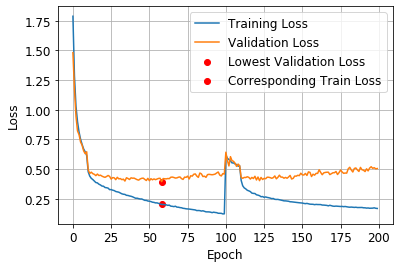

In [43]:
# do not execute if using saved model
plt.plot(running_loss, label="Training Loss")
plt.plot(running_val_loss, label="Validation Loss")
for i in range(len(running_val_loss)):
    if running_val_loss[i] == np.min(running_val_loss):
        lowest_index = i
plt.scatter(lowest_index,
            running_val_loss[lowest_index],
            label="Lowest Validation Loss",
            c="r")
plt.scatter(lowest_index,
            running_loss[lowest_index],
            label="Corresponding Train Loss",
            c="r")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()
plt.show()

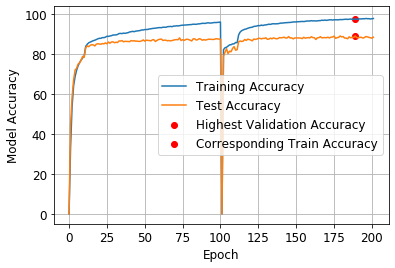

In [44]:
# do not execute if using saved model
plt.plot(running_training_accuracy, label="Training Accuracy")
plt.plot(running_val_accuracy, label="Test Accuracy")
for i in range(len(running_val_accuracy)):
    if running_val_accuracy[i] == np.max(running_val_accuracy):
        highest_index = i
plt.scatter(highest_index,
            running_val_accuracy[highest_index],
            label="Highest Validation Accuracy",
            c="r")
plt.scatter(highest_index,
            running_training_accuracy[highest_index],
            label="Corresponding Train Accuracy",
            c="r")
plt.legend()
plt.ylabel("Model Accuracy")
plt.xlabel("Epoch")
plt.grid()
plt.show()

In [0]:
def confusion_matrix(model):
    """create a confusion matrix for the test images and labels given a set of weights.
    save_as: used for naming when saving the file
    degree: used in case of polynomial regression, default value is 1"""
    device = cpu_or_gpu()
    model.to(device)
    model.eval()
    
    test_loader1 = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=1,
                                               shuffle=True)
    
    for j, (test_images, test_labels) in enumerate(test_loader1):
        test_images, test_labels = test_images.to(
            device), test_labels.to(device)
        outputs = model(test_images)
        _, predicted = torch.max(outputs, 1)
        if j == 0:
          predictions = predicted
          labels = test_labels
        else:
          predictions = torch.cat((predictions, predicted))
          labels = torch.cat((labels, test_labels))
  
    predictions = predictions.to("cpu")
    labels = labels.to("cpu")
    predictions = predictions.squeeze().numpy()
    labels = labels.squeeze().numpy()
    
    # create dataframe and confusion matrix
    data = {'y_Predicted': predictions, 'y_Actual': labels}
    df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins=False)

    fig, ax = plt.subplots(figsize=(10,10))
    # define labels
    x_axis_labels = test_dataset.classes # labels for x-axis
    y_axis_labels = test_dataset.classes # labels for y-axis
    
    hm = sn.heatmap(confusion_matrix/1000, annot=True, ax=ax, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt='0.0%')

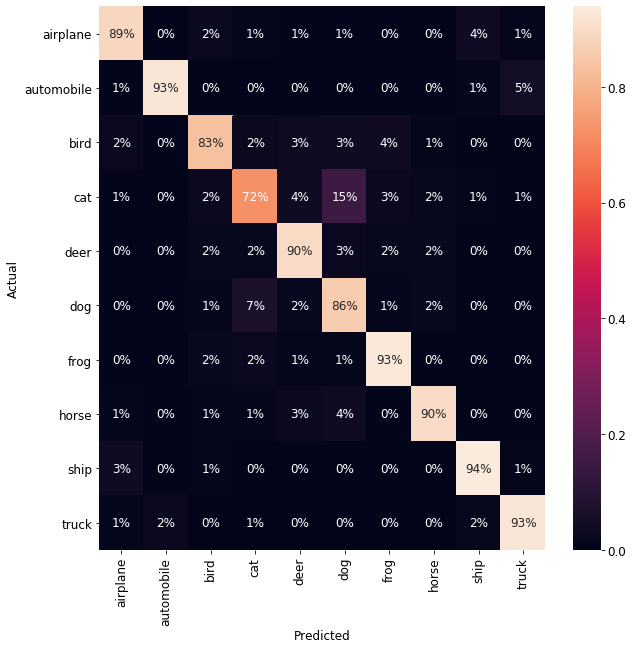

In [109]:
confusion_matrix(model)

# Saving Model State_Dict

In [0]:
# For saving neural network parameters
#torch.save(model.state_dict(), 
           #"finalmodel16Mar2ndrun")  # <----- make sure to update the path if saving new model

# Neural Network Testing

Now we test our model on the untouched test dataset and re-test on the full training dataset to get the final accuracy percentages for our model.

Test Set Accuracy: 88.20%

Training Set Accuracy: 97.74%

## Test on test dataset

In [0]:
# Accuracy on full test dataset (10,000 test images)
def test_on_testing_data(model):
    """for testing model on test set (10,000 test images), batch size of 1000 
    is used for computational purposes and accuracy/loss are averaged after"""

    criterion = nn.CrossEntropyLoss()  # in case not previously defined

    # initialize network to use CPU
    device = torch.device('cpu')
    model.to(device)
    model.eval()

    # initialize accuracy and loss
    test_accuracy = 0
    epoch_loss = 0

    # loop through test batches and send to CPU
    for j, (test_images, test_labels) in enumerate(test_loader):
        test_images, test_labels = test_images.to(
            device), test_labels.to(device)

        # run images through model to create outputs
        test_outputs = model(test_images)

        # compare outputs to actual labels
        epoch_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += accuracy(test_outputs, test_labels)

    # average over the number of batches
    test_accuracy = test_accuracy / len(test_loader)
    test_loss = epoch_loss / len(test_loader)

    # print results
    print("Test Loss is : {a:.2f}".format(a=test_loss))
    print("Test Accuracy is : {a:.2f}%".format(a=test_accuracy))

In [111]:
test_on_testing_data(model)

Test Loss is : 0.53
Test Accuracy is : 88.20%


## Test on training dataset

In [0]:
# Accuracy on full train dataset (50,000 training images) without data augmentation
def test_on_training_data(model):
    """for testing model on training batch (50,000 test images), batch size of 1000 
    is used for computational purposes and accuracy/loss are averaged after"""

    criterion = nn.CrossEntropyLoss()  # in case not previously defined

    # initialize network to use CPU
    device = torch.device('cpu')
    model.to(device)
    model.eval()

    # we want to test on data without additional transformations
    transform_tr1 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    # define new train dataset using above transformations
    train_dataset1 = datasets.CIFAR10('CIFAR10',
                                      train=True,
                                      download=True,
                                      transform=transform_tr1)

    # define new loader with batch size and dataset
    train_loader1 = torch.utils.data.DataLoader(train_dataset1,
                                                batch_size=100,
                                                shuffle=True)
    # initialize accuracy and loss
    test_accuracy = 0  
    epoch_loss = 0

    # loop through test batches and send to CPU
    for j, (test_images, test_labels) in enumerate(train_loader1):
        test_images, test_labels = test_images.to(device), test_labels.to(
            device)

        # run images through model to create outputs
        test_outputs = model(test_images)

        # compare outputs to actual labels
        epoch_loss += criterion(test_outputs, test_labels).item()
        test_accuracy += accuracy(test_outputs, test_labels)

    # average over the number of batches
    test_accuracy = test_accuracy / len(train_loader1)
    test_loss = epoch_loss / len(train_loader1)

    # print results
    print("Training Loss (Full Dataset) is : {a:.2f}".format(a=test_loss))
    print("Training Accuracy (Full Dataset) is : {a:.2f}%".format(
        a=test_accuracy))

In [113]:
test_on_training_data(model)

Files already downloaded and verified
Training Loss (Full Dataset) is : 0.07
Training Accuracy (Full Dataset) is : 97.74%


# Adversarial Attacks

Create a test loader of a single image preparing for further testing on the model with attacks being conducted.

In [0]:
# define loader with a single image loaded at a time
test_loader1 = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=1,
                                           shuffle=True)

## Define Fast Gradient Sign Method(FGSM) attack

In this section we implement adversarial attacks on our established deep convolutional neural networks model. We start from one of the most fundamental attack methods - Fast Gradient Sign Method(FGSM). FGSM works by using the gradient of the model to create an adversarial example. For an input image from CIFAR_10 dataset, the method uses the gradients of the loss with respect to the input image to create a new image(an adversarial image) by adding a perturbation of magnitude in the direction of the gradient that maximises the loss. 
The formula for FGSM is given as the following:
\begin{equation}
x_{adv} \leftarrow x + \epsilon sign(\nabla_xL(F(x),y_{true}))
\end{equation}
where: 

$x_{adv}$ : Perturbed image

$x$ : Original input image

$y$ : Original input label

$\epsilon$ : Small multiplier to the perturbation

$y_{true}$ : True label of the original input

$L$ : Classification loss function







In [0]:
def fgsm(images, epsilon, images_gradient):
    """given a set of images, stored image gradients, and epsilon,
    return fast gradient sign method perturbed image"""
    sign = images.grad.sign()
    new_image = images + epsilon * sign
    return new_image

## Test model with fgsm attack on single image

Given one image and a value of epsilon, show the model prediction with and without pertubation. Visualisation of the image before and after the FGSM attack. It also gives a confidence in the prediction by using softmax on the outputs.

In [0]:
def test_single_prediction(epsilon, model, sample_image_index):
    # Run model on CPU
    device = torch.device('cpu')
    model.to(device)
    model.eval()

    # For randomly sampling one image from the data loader
    indices = np.arange(10000)
    sampler = torch.utils.data.SubsetRandomSampler(indices[sample_image_index-1:sample_image_index])

    test_loader1 = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               sampler=sampler)

    # define sample image out of the batch in the correct shape for visualization
    for test_images, test_labels in test_loader1:
        sample_image = test_images[0, :, :]
        sample_label = test_labels[0]
        test_images, test_labels = test_images.to(device), test_labels.to(device) 

    # fgsm requires that we track gradients
    sample_image.requires_grad = True
    test_images.requires_grad = True

    # run model on single image in test_images and backward pass
    output = model(test_images)

    loss = criterion(output, test_labels)
    model.zero_grad()
    loss.backward()

    # predicted label is the highest value in output
    _, predicted = torch.max(output, 1)

    # calculate confidence in prediction(probability)
    # by applying softmax to output
    confidence = torch.nn.functional.softmax(output, dim=1)
    confidence = torch.max(confidence, 1)

    # fgsm adversarial attack on test_images
    fgsm_images = fgsm(test_images, epsilon, test_images.grad.data)
    fgsm_images = fgsm_images.to(device)

    # run model on single perturbed image
    fgsm_output = model(fgsm_images)

    # predicted label is the highest value in output
    _, fgsm_predicted = torch.max(fgsm_output, 1)

    # calculate confidence in prediction(probability)
    # by applying softmax to output
    fgsm_confidence = torch.nn.functional.softmax(fgsm_output, dim=1)
    fgsm_confidence = torch.max(fgsm_confidence, 1)

    # logging model prediction before and after fgsm attack
    print("True label is: {tl} - {tl_desc}\n\
    \nBefore fgsm - Model prediction: {pred1} - {pred1_desc} with {conf1:.2f}% Confidence\n\
    \nAfter fgsm - Model prediction: {pred2} - {pred2_desc} with {conf2:.2f}% Confidence\n\
    ".format(tl=sample_label,
             tl_desc=train_dataset.classes[sample_label],
             pred1=predicted[0],
             pred1_desc=train_dataset.classes[predicted[0]],
             pred2=fgsm_predicted[0],
             pred2_desc=train_dataset.classes[fgsm_predicted[0]],
             conf1=confidence[0].item() * 100,
             conf2=fgsm_confidence[0].item() * 100))

    # define mean and standard deviation for reversing normalization
    std = tst_std
    mean = tst_mean
    mean = mean[:, None, None]
    std = std[:, None, None]

    # reverse normalization
    sample_image = sample_image * std + mean
    adv_image = fgsm_images * std + mean
    fgsm_vis = epsilon * test_images.grad.sign()

    # list of images and label for visualization
    images_list = [
        sample_image.detach(),
        fgsm_vis.detach()[0, :, :],
        adv_image.detach()[0, :, :]
    ]
    labels_for_vis = ["Original Image", "FGSM Noise", "Perturbed Image"]

    # setup figure with 3 columns and 1
    ax = []
    fig = plt.figure(figsize=(32, 32))
    columns = 3
    rows = 1

    # visualization
    plt.rcParams.update({'font.size': 22})
    for i in range(1, columns * rows + 1):
        ax.append(fig.add_subplot(rows, columns, i))
        ax[-1].set_title(labels_for_vis[i - 1])
        plt.imshow(np.transpose(images_list[i - 1], (1, 2, 0)))

    plt.rcParams.update({'font.size': 12})
    plt.show()

In [117]:
print("Classes are: {}\n".format(test_dataset.classes))

Classes are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Print out a visual comparison between the original image and the corresponding perturbed image. It is shown that our attack has a significant negative impact on our model. As illustrated in the tests below, the visual distinction between two images has become more significant due to the higher distortion on random pixels from the original image as epsilon value increases from 0.01 to 0.1. 

We conclude that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label is: 5 - dog
    
Before fgsm - Model prediction: 5 - dog with 96.85% Confidence
    
After fgsm - Model prediction: 3 - cat with 82.94% Confidence
    


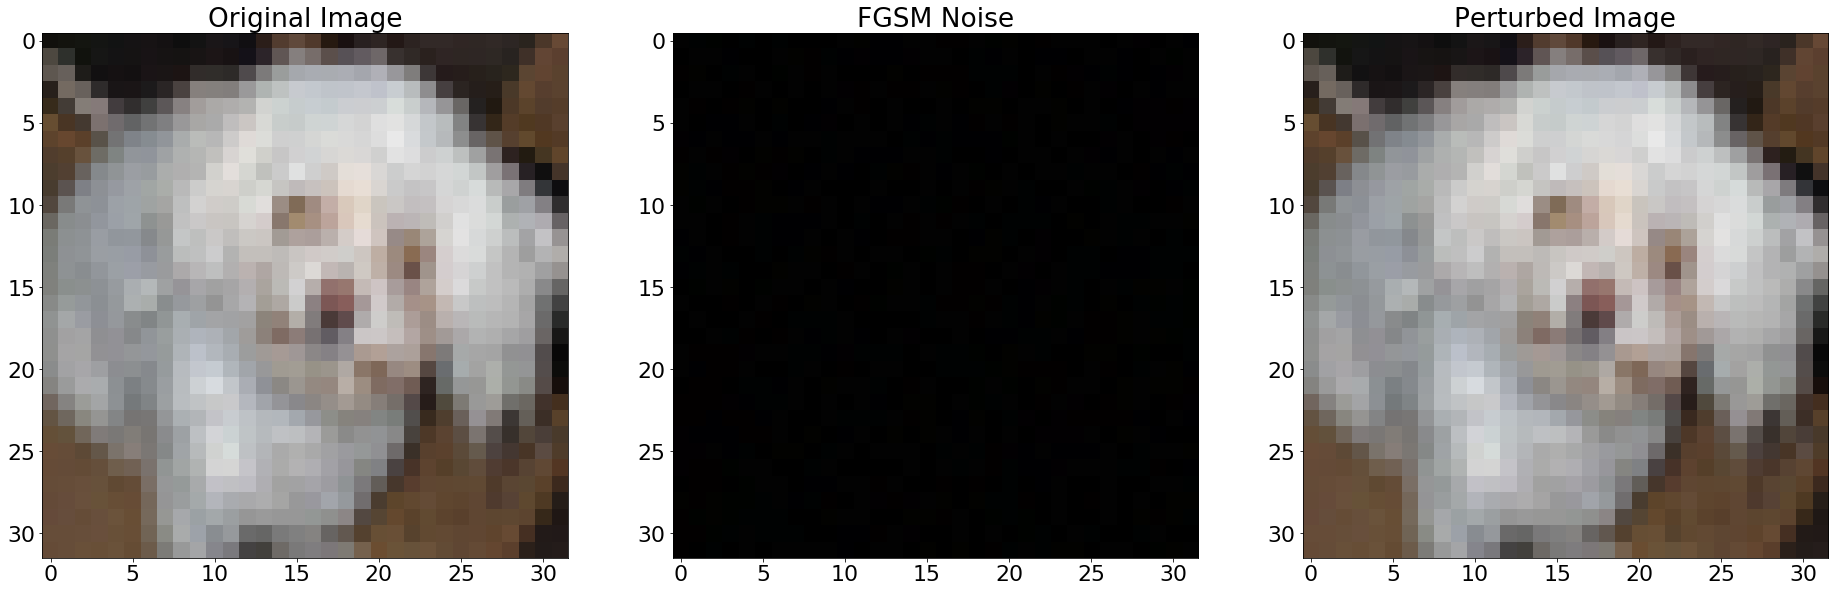

In [118]:
#visualise the difference between original image with perturbed image(with epsilon=0.01)
test_single_prediction(epsilon=0.01, model=model, sample_image_index=1001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label is: 5 - dog
    
Before fgsm - Model prediction: 5 - dog with 96.85% Confidence
    
After fgsm - Model prediction: 3 - cat with 100.00% Confidence
    


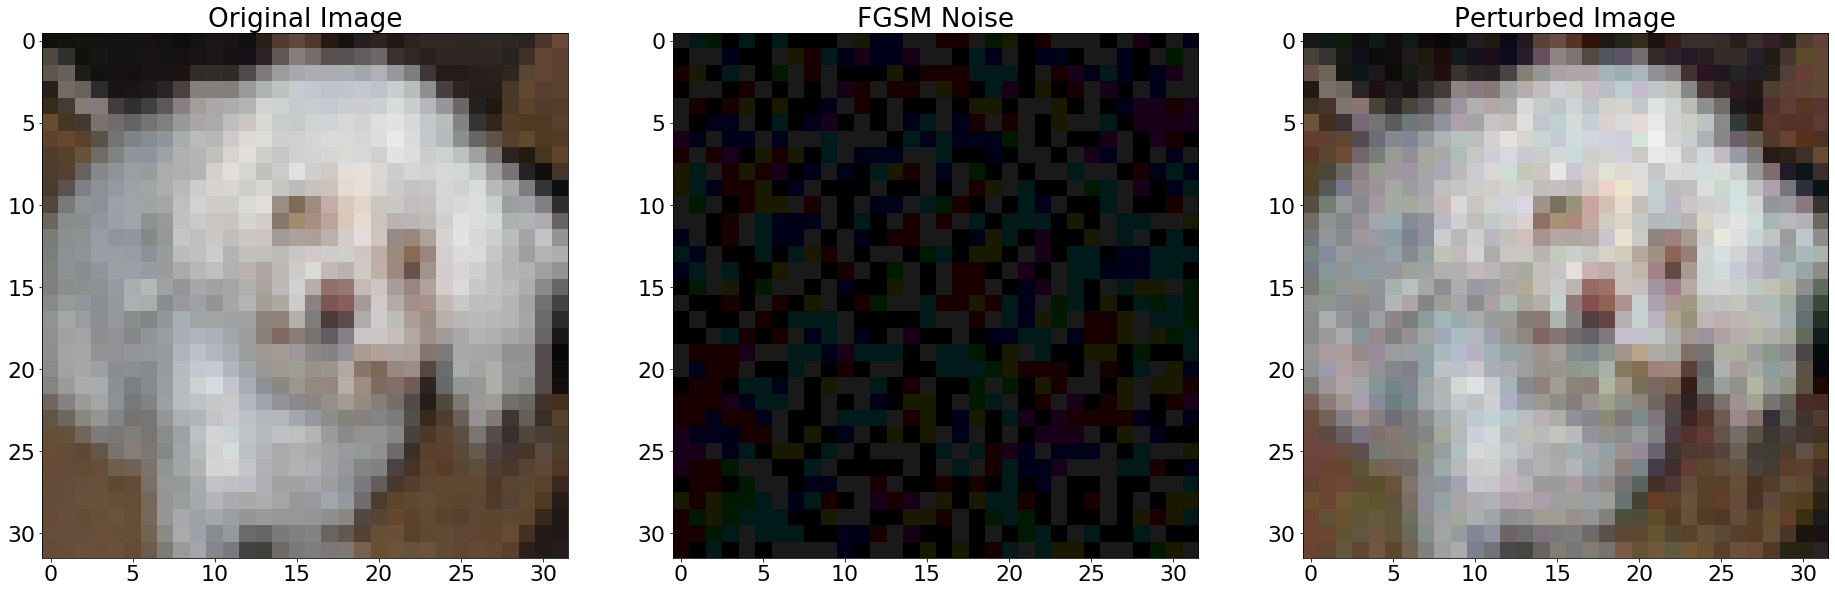

In [119]:
#visualise the difference between original image with perturbed image(with epsilon=0.1)
test_single_prediction(epsilon=0.1, model=model, sample_image_index=1001)

## Test model with fgsm attacks on entire testing dataset

Testing the model's test accuracy against attacks with increasing epsilon values with step size $\frac{1}{255}$:

| Epsilon          | 0.000 | 0.004 | 0.008 | 0.012 | 0.016 | 0.020 | 0.024 | 0.027 | 0.031 | 0.035 | 0.039 | 0.043 | 0.047 | 0.051 | 0.055 | 0.059 | 0.063 | 0.067 | 0.071 | 0.075 | 0.078 |
|------------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|

In [0]:
def test_fgsm(model, device, test_loader1, epsilon):
    """given value of epsilon, determine prediction accuracy on test set
    without and without perturbation"""
    
    device = cpu_or_gpu()
    model.to(device)
    model.eval()

    # Initliaze counter for accuracy
    correct = 0
    adv_examples = []

    # Loop through images and labels one by one
    for images, labels in test_loader1:

        # Send the data and label to the device
        images, labels = images.to(device), labels.to(device)

        # Run image through model
        images.requires_grad = True
        output = model(images)
        init_pred = output.max(
            1, keepdim=True)[1]

        # If the initial prediction is wrong don't attack
        if init_pred.item() != labels.item():
            continue

        # Calculate the loss
        loss = criterion(output, labels)

        # Zero all existing gradients
        model.zero_grad()

        # Backward pass to get gradients
        loss.backward()
        images_gradient = images.grad.data

        # FGSM Attack and re-classification
        perturbed_data = fgsm(images, epsilon, images_gradient)
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(
            1, keepdim=True)[1]  # get the index of the max log-probability
        if final_pred.item() == labels.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader1))
    print("Epsilon: {:.3f}\tTest Accuracy = {} / {} = {}".format(
        epsilon, correct, len(test_loader1), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
# List of epsilon values to test
epsilon = np.array((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))/255

In [128]:
accuracies = []
examples = []

print("Epsilons to test: {}/255".format(epsilon*255))
# Run test for each epsilon
for eps in epsilon:
    acc, ex = test_fgsm(model, device, test_loader1, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilons to test: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]/255
Epsilon: 0.000	Test Accuracy = 8820 / 10000 = 0.882
Epsilon: 0.004	Test Accuracy = 8110 / 10000 = 0.811
Epsilon: 0.008	Test Accuracy = 7383 / 10000 = 0.7383
Epsilon: 0.012	Test Accuracy = 6603 / 10000 = 0.6603
Epsilon: 0.016	Test Accuracy = 5897 / 10000 = 0.5897
Epsilon: 0.020	Test Accuracy = 5261 / 10000 = 0.5261
Epsilon: 0.024	Test Accuracy = 4842 / 10000 = 0.4842
Epsilon: 0.027	Test Accuracy = 4489 / 10000 = 0.4489
Epsilon: 0.031	Test Accuracy = 4250 / 10000 = 0.425
Epsilon: 0.035	Test Accuracy = 4079 / 10000 = 0.4079
Epsilon: 0.039	Test Accuracy = 3933 / 10000 = 0.3933
Epsilon: 0.043	Test Accuracy = 3807 / 10000 = 0.3807
Epsilon: 0.047	Test Accuracy = 3693 / 10000 = 0.3693
Epsilon: 0.051	Test Accuracy = 3587 / 10000 = 0.3587
Epsilon: 0.055	Test Accuracy = 3482 / 10000 = 0.3482
Epsilon: 0.059	Test Accuracy = 3394 / 10000 = 0.3394
Epsilon: 0.063	Test Accuracy = 3305 / 10000 = 

The performance of our model decreases significantly against an increasing epsilon due to the larger distortion created by higher epsilon values:

| Epsilon          | 0.000 | 0.004 | 0.008 | 0.012 | 0.016 | 0.020 | 0.024 | 0.027 | 0.031 | 0.035 | 0.039 | 0.043 | 0.047 | 0.051 | 0.055 | 0.059 | 0.063 | 0.067 | 0.071 | 0.075 | 0.078 |
|------------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Test Accuracy(%) | 88.20 | 81.10 | 73.83 | 66.03 | 58.97 | 52.61 | 48.42 | 44.89 | 42.50 | 40.79 | 39.33 | 38.07 | 36.93 | 35.87 | 34.82 | 33.94 | 33.05 | 32.24 | 31.43 | 30.70 | 30.08 |

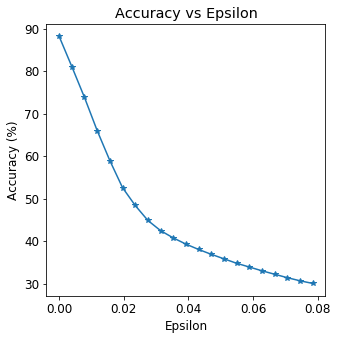

In [129]:
# visualization of epsilon vs test accuracy
plt.figure(figsize=(5, 5))
plt.plot(epsilon, np.array(accuracies)*100, "*-")
plt.yscale("linear")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.show()

# Defending From Adversarial Attacks

Implementing one of the most common defence techniques consisting of introducting inputs that have already been attacked and including them as part of the original training set to train a more robust network. This technique is known as Adversarial Training which can be formulated as the following:

\begin{equation}\label{eq:}
L(F(x),y_{true}) = c*L(F(x),y_{true}) + (1-c)*L(F(x),x + \epsilon sign(\nabla_x L(F(x),y_{true}), y_{true})
\end{equation}

where: 

$x + \epsilon sign(\nabla_x L(F(x),y_{true}))$ : FGSM-generated     adversarial samples

$c$ : the hyperparameter that is used to balance the accuracy on original and adversarial samples


For CIFAR10 dataset, We generate our robust model from the target model by adding some perturbed images derived from the original images using the FGSM attack method.

## Building robust model 

In [130]:
# Use this cell if training a new model
model_robust = Neural_Network()
device = cpu_or_gpu()
model_robust.to(device)

Neural_Network(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(100, 200, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(200, 300, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(300, 400, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(400, 500, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4500, out_features=10, bias=True)
  (activ1): ReLU()
)

In [0]:
# Use this cell if loading a saved model
model = Neural_Network()
device = cpu_or_gpu()
model.to(device)
model.load_state_dict(
    torch.load("robust_model"))  # <------- Insert path of saved model as string here

model.eval()

In [131]:
# Summary of layers, output shape, parameters, and size
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 32, 32]           2,800
              ReLU-2          [-1, 100, 32, 32]               0
         MaxPool2d-3          [-1, 100, 16, 16]               0
            Conv2d-4          [-1, 200, 17, 17]          80,200
              ReLU-5          [-1, 200, 17, 17]               0
         MaxPool2d-6            [-1, 200, 8, 8]               0
            Conv2d-7            [-1, 300, 9, 9]         240,300
              ReLU-8            [-1, 300, 9, 9]               0
         MaxPool2d-9            [-1, 300, 4, 4]               0
           Conv2d-10            [-1, 400, 5, 5]         480,400
             ReLU-11            [-1, 400, 5, 5]               0
        MaxPool2d-12            [-1, 400, 2, 2]               0
           Conv2d-13            [-1, 500, 3, 3]         800,500
             ReLU-14            [-1, 50

## Robust training function

The training function randomly inserts adversarial samples of the corresponding original images under a probability of 50% which is the hyperparameter $c$ defined in the formula.

In [0]:
def train_robust(number_of_epochs):

    # Initial hyperparameters
    number_of_epochs = number_of_epochs
    step_size = 0.01
    momentum_parameter = 0.9
    lambda1 = 0.001

    # L1 Regularization
    all_linear1_params = torch.cat(
        [x.view(-1) for x in model_robust.fc1.parameters()])
    l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)

    # Initialize optimiser
    optimiser = optim.SGD(model_robust.parameters(),
                          lr=step_size,
                          momentum=momentum_parameter)

    # initialize lists for running counts of loss and accuracy
    running_loss = []
    running_val_loss = []
    running_loss_robust = []
    running_training_accuracy = []
    running_training_accuracy.append(0)
    running_val_accuracy = []
    running_val_accuracy.append(0)

    print("Log -- Step size: {}, Momentum: {}, batch_size = {}".format(
        step_size, momentum_parameter, train_batch_size))
    
    # loop for epochs
    for k in range(number_of_epochs):
        model_robust.train()
        device = cpu_or_gpu()
        model_robust.to(device)

        # initialize epoch loss and training accuracy
        epoch_loss = 0
        epoch_loss_robust = 0
        training_accuracy = 0


        # handle reducing step size at various iterations

        step_size = reduce_step_size(iteration_cutoff=10,
                                     old_step_size=step_size,
                                     new_step_size=0.001,
                                     epoch=k)

        optimiser = optim.SGD(model_robust.parameters(),
                              lr=step_size,
                              momentum=momentum_parameter)

        # Main Training Loop
        for j, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            images.requires_grad = True
            
             # pass inputs through model one time to get regular model loss
            optimiser.zero_grad()
            outputs = model_robust(images)
            loss = criterion(outputs, labels)+ (l1_regularization/len(images))
            loss.backward(retain_graph=True)
            
            # with probablity p=0.5, perturb images using random epsilon between 0 and 0.3
            #probability = int(np.random.randint(1,10,1))
            #if probability < 2:
            images = fgsm(images, int(np.random.randint(1,20,1))*(1/255), images.grad.sign())
            
            for i in [0.01, 0.05, 0.1, 0.15, 0.2]:
              images_add = fgsm(images, i, images.grad.sign())
              torch.cat([images, images_add], dim=0)
            
            # pass new inputs through model a second time to get robust model loss
            optimiser.zero_grad()
            outputs = model_robust(images)
            loss_robust = criterion(outputs, labels) + (l1_regularization/len(images))
            loss_robust.backward(retain_graph=True)
            optimiser.step()

            epoch_loss += loss.item()
            epoch_loss_robust += loss_robust.item()
            training_accuracy += accuracy(outputs, labels)

        # Caclulate average loss and accuracy for each epoch
        running_loss.append(epoch_loss / len(train_loader))
        running_loss_robust.append(epoch_loss_robust / len(train_loader))
        running_training_accuracy.append(training_accuracy / len(train_loader))

        # Validation test once per epoch
        device = torch.device('cpu')
        model_robust.eval()
        model_robust.to(device)
        val_images, val_labels = iter(val_loader).next()
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model_robust(val_images) + (l1_regularization/len(val_images))
        val_loss = criterion(val_outputs, val_labels).item()

        # Store validation loss and accuracy
        running_val_loss.append(val_loss)
        val_accuracy = accuracy(val_outputs, val_labels)
        running_val_accuracy.append(val_accuracy)
        
        # Running log
        if k % 1 == 0:
            print(
                "Epoch {a}/{b} -> Tr. Loss (Original) = {c:.4f}, Tr. Loss (Robust) = {g:.4f} Val. Loss = {d:.4f}, Tr. Acc = {e:.2f}, Val. Acc = {f:.2f}"
                .format(a=k,
                        b=number_of_epochs,
                        c=running_loss[-1],
                        d=running_val_loss[-1],
                        e=running_training_accuracy[-1],
                        f=running_val_accuracy[-1],
                        g=running_loss_robust[-1]))

    print("Final Epoch {} -> Loss = {}".format(k, running_loss_robust[-1]))

    return running_loss, running_loss_robust, running_val_loss, running_training_accuracy, running_val_accuracy

In [133]:
running_loss1, running_loss_robust, running_val_loss1, running_training_accuracy1, running_val_accuracy1 = train_robust(number_of_epochs=50)

Log -- Step size: 0.01, Momentum: 0.9, batch_size = 32
Epoch 0/50 -> Tr. Loss (Original) = 1.7929, Tr. Loss (Robust) = 1.8191 Val. Loss = 1.4446, Tr. Acc = 32.12, Val. Acc = 45.54
Epoch 1/50 -> Tr. Loss (Original) = 1.3009, Tr. Loss (Robust) = 1.3607 Val. Loss = 1.1436, Tr. Acc = 51.03, Val. Acc = 58.92
Epoch 2/50 -> Tr. Loss (Original) = 1.0487, Tr. Loss (Robust) = 1.1218 Val. Loss = 0.9845, Tr. Acc = 60.87, Val. Acc = 64.68
Epoch 3/50 -> Tr. Loss (Original) = 0.9189, Tr. Loss (Robust) = 1.0082 Val. Loss = 0.9194, Tr. Acc = 65.30, Val. Acc = 67.94
Epoch 4/50 -> Tr. Loss (Original) = 0.8315, Tr. Loss (Robust) = 0.9285 Val. Loss = 0.7749, Tr. Acc = 68.34, Val. Acc = 72.04
Epoch 5/50 -> Tr. Loss (Original) = 0.7653, Tr. Loss (Robust) = 0.8763 Val. Loss = 0.7634, Tr. Acc = 70.48, Val. Acc = 73.36
Epoch 6/50 -> Tr. Loss (Original) = 0.7190, Tr. Loss (Robust) = 0.8259 Val. Loss = 0.7342, Tr. Acc = 72.09, Val. Acc = 74.30
Epoch 7/50 -> Tr. Loss (Original) = 0.6832, Tr. Loss (Robust) = 0.8034

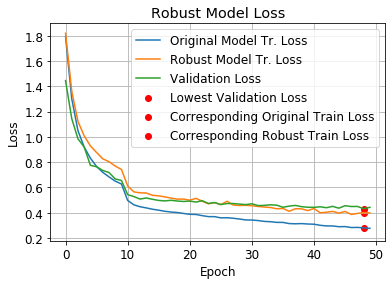

In [134]:
plt.plot(running_loss1, label="Original Model Tr. Loss")
plt.plot(running_loss_robust, label="Robust Model Tr. Loss")
plt.plot(running_val_loss1, label="Validation Loss")
for i in range(len(running_val_loss1)):
    if running_val_loss1[i] == np.min(running_val_loss1):
        lowest_index = i
plt.scatter(lowest_index,
            running_val_loss1[lowest_index],
            label="Lowest Validation Loss",
            c="r")
plt.scatter(lowest_index,
            running_loss1[lowest_index],
            label="Corresponding Original Train Loss",
            c="r")
plt.scatter(lowest_index,
            running_loss_robust[lowest_index],
            label="Corresponding Robust Train Loss",
            c="r")
plt.legend()
plt.title("Robust Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()
plt.show()

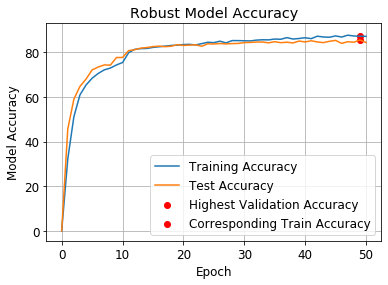

In [135]:
plt.plot(running_training_accuracy1, label="Training Accuracy")
plt.plot(running_val_accuracy1, label="Test Accuracy")
for i in range(len(running_val_accuracy1)):
    if running_val_accuracy1[i] == np.max(running_val_accuracy1):
        highest_index = i
plt.scatter(highest_index,
            running_val_accuracy1[highest_index],
            label="Highest Validation Accuracy",
            c="r")
plt.scatter(highest_index,
            running_training_accuracy1[highest_index],
            label="Corresponding Train Accuracy",
            c="r")
plt.legend()
plt.title("Robust Model Accuracy")
plt.ylabel("Model Accuracy")
plt.xlabel("Epoch")
plt.grid()
plt.show()

In [137]:
test_on_testing_data(model_robust)

Test Loss is : 0.42
Test Accuracy is : 85.70%


In [0]:
# For saving neural network parameters
torch.save(model_robust.state_dict(), 
           "robust_model")  # <----- make sure to update the path if saving new model

When we previously ran the tests below we got the following results:

**Epsilon = 0.01**

Before fgsm - Model prediction: 5 - dog with 96.85% Confidence

After fgsm - Model prediction: 3 - cat with 82.94% Confidence

**Epsilon = 0.1**

Before fgsm - Model prediction: 5 - dog with 96.85% Confidence
    
After fgsm - Model prediction: 3 - cat with 100.00% Confidence

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label is: 5 - dog
    
Before fgsm - Model prediction: 5 - dog with 98.24% Confidence
    
After fgsm - Model prediction: 5 - dog with 95.49% Confidence
    


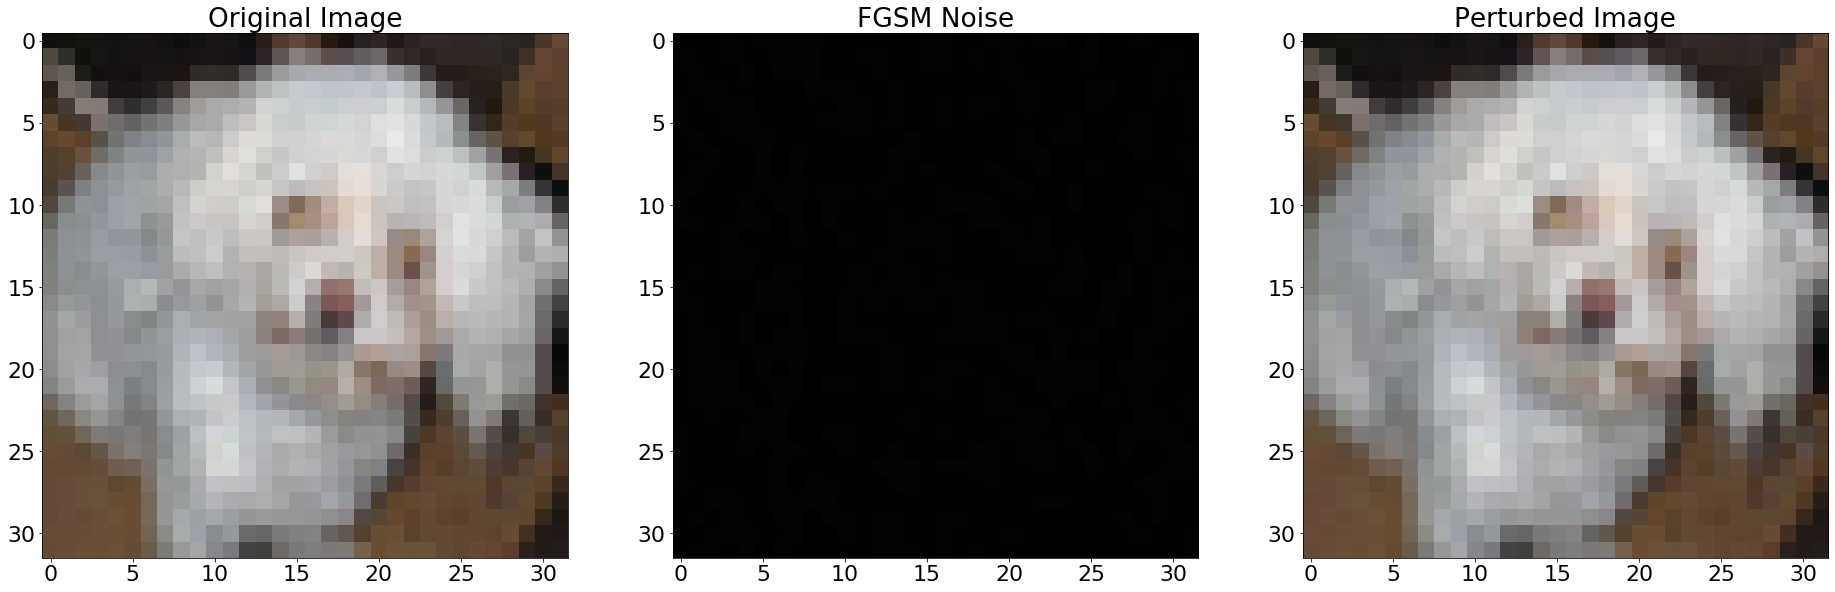

In [138]:
test_single_prediction(epsilon=0.01, model=model_robust, sample_image_index=1001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label is: 5 - dog
    
Before fgsm - Model prediction: 5 - dog with 98.24% Confidence
    
After fgsm - Model prediction: 3 - cat with 84.30% Confidence
    


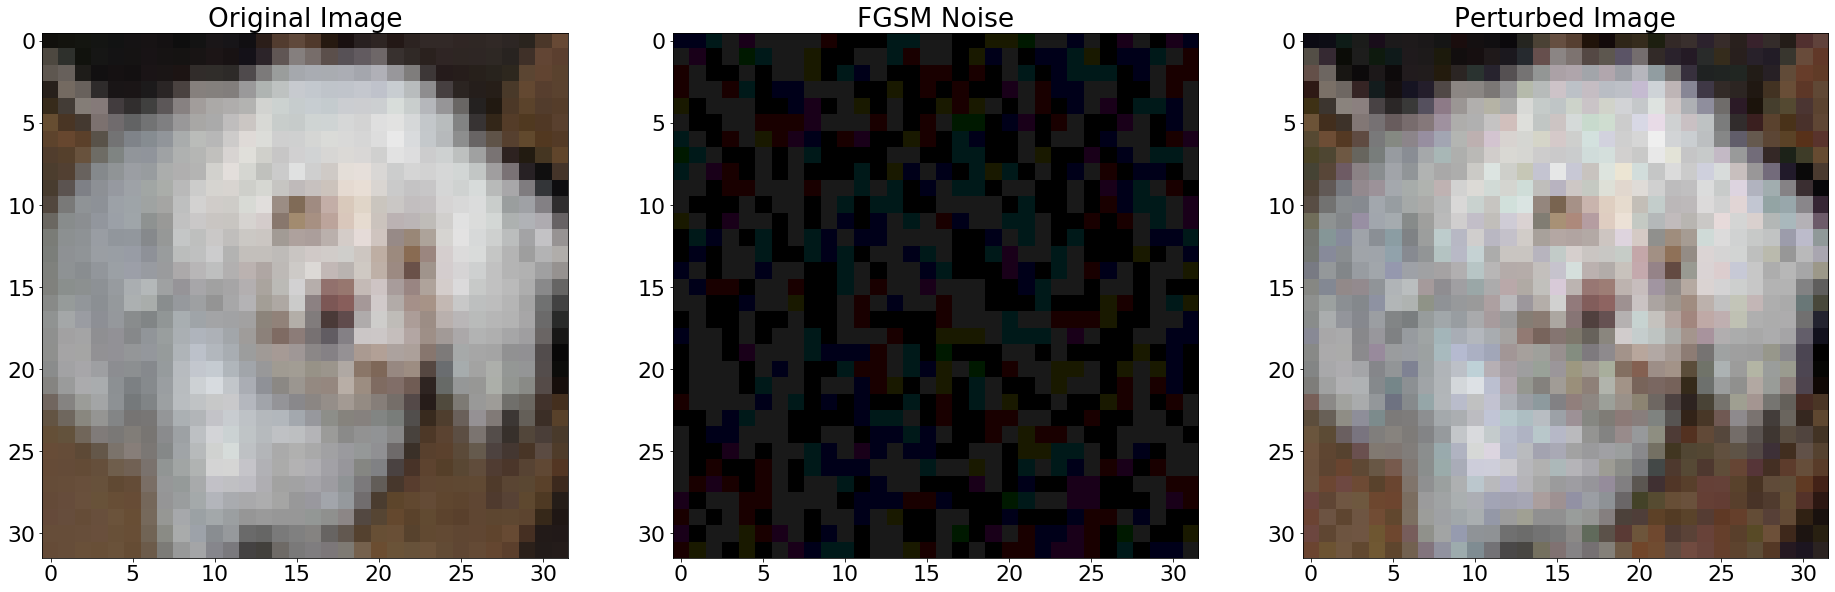

In [139]:
test_single_prediction(epsilon=0.1, model=model_robust, sample_image_index=1001)

So our robust model works much better for the small epsilon value 0.01 that we have been using to attack our model. However, for epsilon = 0.1, which we did not have in our model, it only does slightly better.

Now lets try on the entire testing set.

In [140]:
accuracies_robust = []
examples_robust = []

# Run test for each epsilon
for eps in epsilon:
    acc_robust, ex_robust = test_fgsm(model_robust, device, test_loader1, eps)
    accuracies_robust.append(acc_robust)
    examples_robust.append(ex_robust)

Epsilon: 0.000	Test Accuracy = 8570 / 10000 = 0.857
Epsilon: 0.004	Test Accuracy = 8260 / 10000 = 0.826
Epsilon: 0.008	Test Accuracy = 7937 / 10000 = 0.7937
Epsilon: 0.012	Test Accuracy = 7592 / 10000 = 0.7592
Epsilon: 0.016	Test Accuracy = 7226 / 10000 = 0.7226
Epsilon: 0.020	Test Accuracy = 6854 / 10000 = 0.6854
Epsilon: 0.024	Test Accuracy = 6484 / 10000 = 0.6484
Epsilon: 0.027	Test Accuracy = 6151 / 10000 = 0.6151
Epsilon: 0.031	Test Accuracy = 5809 / 10000 = 0.5809
Epsilon: 0.035	Test Accuracy = 5510 / 10000 = 0.551
Epsilon: 0.039	Test Accuracy = 5190 / 10000 = 0.519
Epsilon: 0.043	Test Accuracy = 4889 / 10000 = 0.4889
Epsilon: 0.047	Test Accuracy = 4637 / 10000 = 0.4637
Epsilon: 0.051	Test Accuracy = 4351 / 10000 = 0.4351
Epsilon: 0.055	Test Accuracy = 4099 / 10000 = 0.4099
Epsilon: 0.059	Test Accuracy = 3849 / 10000 = 0.3849
Epsilon: 0.063	Test Accuracy = 3628 / 10000 = 0.3628
Epsilon: 0.067	Test Accuracy = 3412 / 10000 = 0.3412
Epsilon: 0.071	Test Accuracy = 3191 / 10000 = 0.31

The test results reflect that our robust model works relatively well against various scales of FGSM attacks compared to our original model:

| Epsilon          | 0.000 | 0.004 | 0.008 | 0.012 | 0.016 | 0.020 | 0.024 | 0.027 | 0.031 | 0.035 | 0.039 | 0.043 | 0.047 | 0.051 | 0.055 | 0.059 | 0.063 | 0.067 | 0.071 | 0.075 | 0.078 |
|------------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Test Accuracy(%) (O) | 88.20 | 81.10 | 73.83 | 66.03 | 58.97 | 52.61 | 48.42 | 44.89 | 42.50 | 40.79 | 39.33 | 38.07 | 36.93 | 35.87 | 34.82 | 33.94 | 33.05 | 32.24 | 31.43 | 30.70 | 30.08 |
| Test Accuracy(%) (R) | 85.70 | 82.60 | 79.37 | 75.92 | 72.26 | 68.54 | 64.84 | 61.51 | 58.09 | 55.10 | 51.90 | 48.89 | 46.37 | 43.51 | 40.99 | 38.49 | 36.28 | 34.12 | 31.91 | 29.98 | 28.12 |

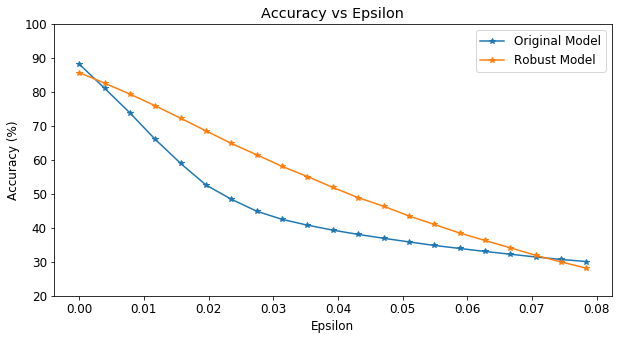

In [143]:
# visualization of epsilon vs test accuracy
plt.figure(figsize=(10, 5))
plt.plot(epsilon, np.array(accuracies)*100, "*-", label="Original Model")
plt.plot(epsilon, np.array(accuracies_robust)*100, "*-", label="Robust Model")
plt.yticks([20,30,40,50,60,70,80,90,100])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

#### Summary of the Attack and Defence results

There are still considerable amount of downsides of our robust model as the test accuracy is relatively low compared to our final model without any attacks being conducted and the FGSM attack will break the model with higher epsilon values. 

This type of adversarial training on its own is not sufficient, as it is impossible to anticipate every type of attack that could be performed on the images. This method can be seen as a complementary enhancement to other types of defenses. 

# Conclusion

We developed a neural network with 5 convolutional layers and 1 fully connected layer and achieved a maximum test accuracy of 88.20% on CIFAR-10. Using strategies such as pre-training data augmentation (normalisation, cropping and flipping) as well as regularisation techniques included (max pooling and dropout). We then implemented an adversarial attack, fast sign gradient method (FGSM), which then showed our neural network model was vulnerable to adversarial attacks even with only small epsilon values. For instance, epsilon values as small as 0.008 were able to reduce the accuracy of our model by 15%. However, we further developed our neural network model by defending against such attacks by incorporating adversarial attacks into the training of our model.

We did this by incorporating a number of randomly perturbed images with a probability of 50% in each epoch and then trained our model with these images to make it more robust. This improved the generalisation of the model and an epsilon value of 0.008 caused a 6% decrease in accuracy in comparison to 15% in the original model. We highlighted the accuracy differences between our original model and the robust model. Although the initial accuracy in the robust model was slighted lower than the original model, the robust model proved to better at classifying perturbed images. Given more time, we further aim to improve the model by exploring different network architecture structures to increase the accuracy and defending against more powerful attacks. 

# References

Pytorch website: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
<br>
<br>
Benjamin Graham, Spatially-sparse convolutional neural networks, September 2014,arXiv:1409.6070v1 [cs.CV], URL: https://arxiv.org/pdf/1409.6070.pdf
<br>
<br>
Vincent Dumoulin and Francesco Visin, A guide to convolution arithmetic for deep
learning, March 24 2016,
arXiv:1603.07285v1 [stat.ML], URL:https://arxiv.org/pdf/1603.07285v1.pdf
<br>
<br>
Mark D. McDonnell and Tony Vladusich, Enhanced Image Classification With a Fast-Learning Shallow Convolutional Neural Network, Computer Science, Neural and Evolutionary Computing, Cornell University, March 16 2015, arXiv:1503.04596 [cs.NE], URL:https://arxiv.org/abs/1503.04596
<br>
<br>
Derek Wang, Chaoran Li, Sheng Wen, Surya Nepal, and Yang Xiang, Defending against Adversarial Attack towards
Deep Neural Networks via Collaborative Multi-task Training, December 5 2018, arXiv:1803.05123 [cs.LG], URL:https://arxiv.org/abs/1803.05123v3
<br>
<br>
Yi Wang, Zhen-Peng Bian, Junhui Hou, and Lap-Pui Chau, Convolutional Neural Networks with Dynamic Regularization, September 26 2019, arXiv:1909.11862 [cs.CV], URL:https://arxiv.org/abs/1909.11862
